In [1]:
# CLASSIFICATION TASK

In [2]:
# let's download famous MNIST hand-written digits dataset

from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

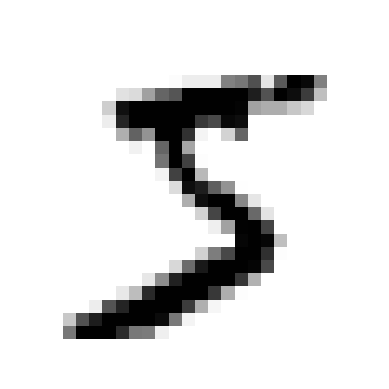

In [5]:
# there are 70,000 images and each image has 784 features : bcoz each image is 28 x 28 pixel
# each pixel represent the intensity of the picture with 0 (white) to 255 (black)
# let's take a digit and display it in a vector, reshape it by 28 x 28 array and display it

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[:1].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# let's look at the target label
y[0]

'5'

In [7]:
# since the y labels are string and ML algorithm will work on numeric data
# let's cast our y to integer
import numpy as np

y = y.astype(np.uint8)

In [8]:
# first 60,000 images are training set and last 10,000 images are test set
# the training set is already shuffled for us, which will be good for us since it will confirm all the cross-validation folds will be similar
# also, some ML algorithms are sensitive to the order of the training and might perform poor if similar instances in a row

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

In [9]:
# for now let's just work on one digit, 5 or not 5
# creating a target vector for this classification task

y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

In [10]:
# we can choose our classifier now. Let's use Stochastic Gradiant Descent 

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# we can use the classifier to detect the number
sgd_clf.predict(some_digit)

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [12]:
# performance measure using cross-validation

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# high accuray, but let's again use very basic classifier this with BaseEstimator

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
# again very high accuracy for the baseestimator but it is because we have very few 5s 
# so, for the classifiers accuracy is not a prefered performance measure, spacially when we are working with skewed datasets
# a better way to measure the performance of the classifier is confusion matrix : e.g. the number of time the classifier confused with the images of 3 as 5
# let's have a set of predictions to be ready for our confusion matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# similar to corss_val_score, cross_val_predict performs k-fold corss validation, and returns predictions made on each fold

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
# the confusion matrix each row represents an actual class
# the first row of the class represents non-5 images: 53892 actual non-5 correctly classified as non-5, 687 actual non-5 wrongly classified as 5
# second row represents images of 5s: 1891 wrongly classified as non-5s and 3530 correctly classified as 5s
# we need to see high true positives and true negatives, let's check perfect predictions confusion matrix

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [17]:
# we can certainly check the confusion matrix of the classifier
# however precision is sometimes more concise metric, Precision is basically accuracy of positive predictions
# precision = true positive / true positive + false positive 
# precision is used with "recall" (another metric) or True Positive rate, also called sensitivity
# recall = true positive / true positive + false negative
# Scikkit-Learn provides class to compute these metrics

from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
# now we can realize that the classifier is not so good as what the accuracy metric tells us
# When it comes to image representation as 5, it is correct 0.83% of the time, and it deteced only 0.65% of the total 5s.
# we have a combined metric of precision and recall, called "F1-Score" which might be helpful in many scenarios
# equation : F1-Score = (2/(1/precision)+(1/recall))
# scikit learn metric class also provides this metric

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [20]:
# F1 score favours to classifier which have similar precision and recall
# this is not what we want in all the cases, in some cases we care mostly about precision and vice-versa
# unfortunately, we can't have both ways: increasing precision will reduces recall and vice-versa :  a precision/recall trade-off
# So, basically our stochastic gradiant decent computes the score based on decision function for each instance
# if the score is greater than threshold, it assigns the instance to the positive class, otherwise it assigns it to negative class
# scikit-learn does not allow us to set the threshold directly but we have access to the decision scores
# instead of calling classifier's prediction function, we can call decision_function(), which returns the score for each instance, then we can use the threshold

y_scores = sgd_clf.decision_function(X[:1].values)
y_scores

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [23]:
# this confirms that raising threshold decreses recall
# the digit is 5, so when the threshold is 0 it detects correct as 5 but when the threshold increases to 8000 it detects false as non-5
# So, ultimately, here is the way we can decide the precision-recall threshold:
    # 1) use the cross_val_predict() function to get the scores of all the instances in the training set
    # 2) this time in the cross_val_predict() function, specify method = "decision_function"
    # 3) with these scores we will use the precision_recall_curve() function to compute precision and recall for all possible thresholds
    # 4) finally, with matplotlib, we can plot the curve

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

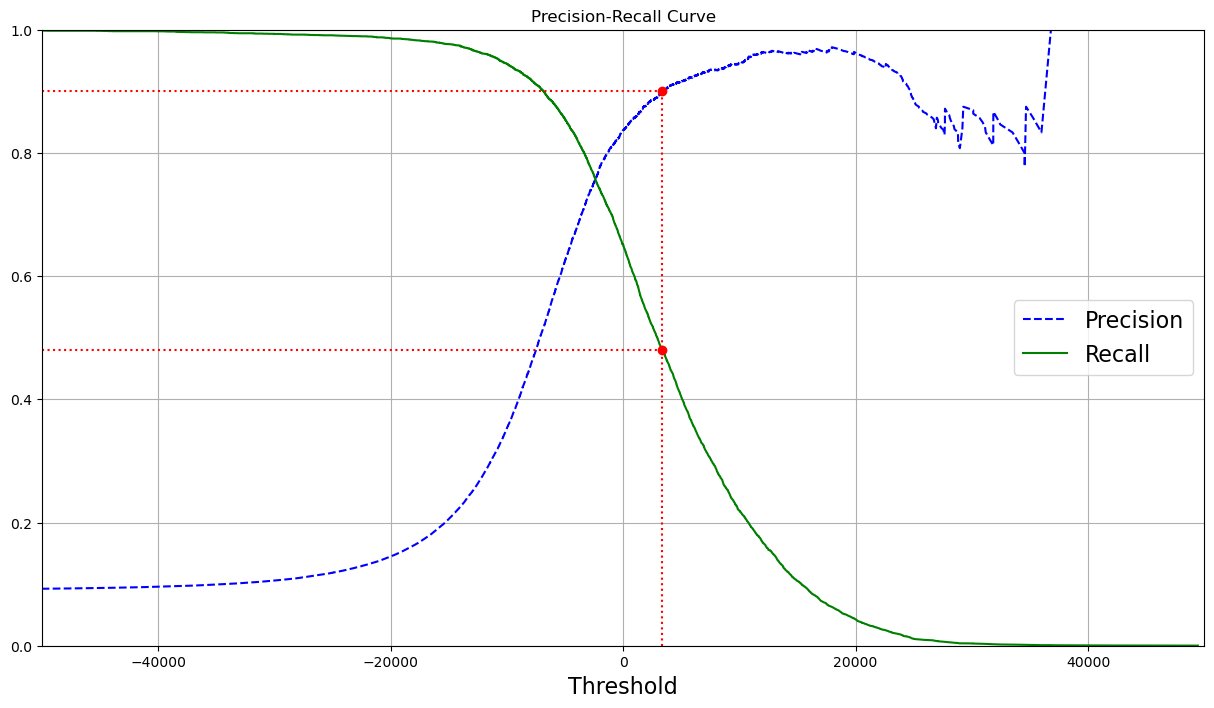

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.title('Precision-Recall Curve')
    plt.legend(loc="center right", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plt.figure(figsize=(15, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precisions = thresholds[np.argmax(precisions >= 0.90)]

plt.plot([threshold_90_precisions, threshold_90_precisions], [0., .9], "r:")
plt.plot([-50000, threshold_90_precisions], [.9, .9], "r:")
plt.plot([-50000, threshold_90_precisions], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precisions], [.9], "ro")
plt.plot([threshold_90_precisions], [recall_90_precision], "ro")
plt.show()

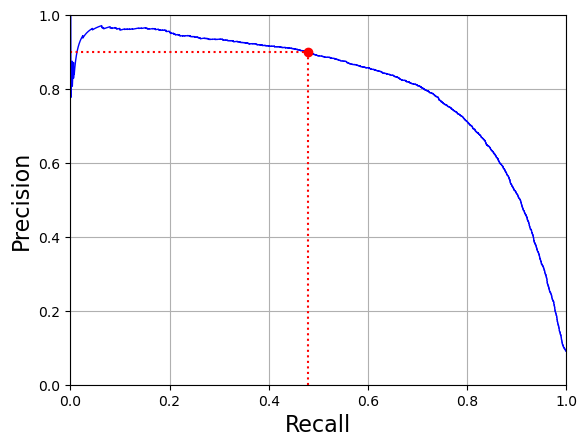

In [27]:
# we can also plot precision vs recall curve to find out the threshold
def precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "-b", linewidth=1)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., .9], "r:")
plt.plot([0, recall_90_precision], [.9, .9], "r:")
plt.plot([recall_90_precision], [.9], "ro")
plt.show()

In [28]:
# to make predictions, intead of calling the predict() method we can do this

y_train_pred_90 = (y_scores >= threshold_90_precisions)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [31]:
# so, we have a classifier with 90% precision, but it won't be helpful if it's recall is too low
# The ROC curve (receiver operating characteristic) is another common tool we can employ
# Instead of plotting precision and recall, the roc curve plots true positive rate against false positive (specificity : true negative rate)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

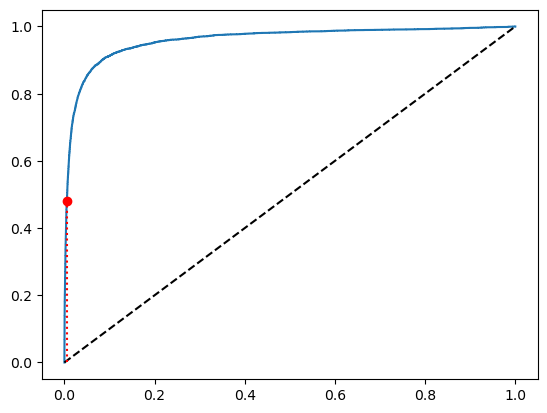

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], "k--")

plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [33]:
# once again there's a trade off, the higher the recall (TPR) more false positive rate the classifier produces
# dotted line represents the ROC curve of purely random classifier
# a good classifier stays as far away from that line as possible (towards the top left cornor)

In [34]:
# so, one way to compare the classifiers is to measure the area under the curve (AUC)
# a perfect classifier will have ROC AUC equal to 1, ramdon classifier will have ROC AUC around 0.5
# here is scikit-learn's function to compute roc auc

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
# ROC curve is so similar to precision-recall curve 
# We can use precision-recall curve whenever the positive class is rare, or when we care more about the false positive then false negatives
# Otherwise it's good to use the ROC curve
# here looking at the roc_auc_score .96 we can think that the classifier is really good, but infact there are only few 5s compared to the non-5s
# PR curve makes it clear that the classifier has room for improvement 

In [36]:
# now we can try a RandomForestClassifier and compare the ROC Curve, also compute the roc_auc curve 

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [37]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

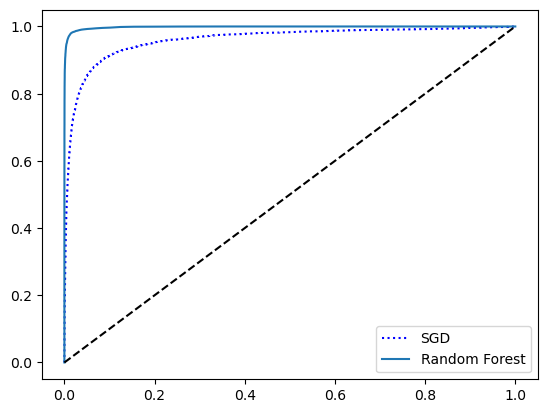

In [38]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [39]:
# we can notice RandomForestClassifier is superior, and haveing higher AUC. Also, it's close to top-left cornor
# let's compute roc_auc_score

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [40]:
# let's also see precision and recall scores
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [41]:
# precision score
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [44]:
# recall score
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [45]:
# Multiclass classification: 
    #some algorithms are natively appropriate for multiclass classification such as Random Forest Classifier, 
    #Logistic Regression, Naive Bayes
# However, there are strategies to use stricktly binary classifier for multiclass classification. (SVM, SGD)
    # we can employ one-versus-the-rest: for detecting 0-9, train 10 different classifiers to detect o or non-zero, 1 or non-1 and so on
        #then to classify an image get the decision score for each classifier with highest score
    # Or we can employ One-versus-one: train classifiers for every pair of the digits, e.g., 0 or 1, 1 or 2 and so on.
        #for MNIST classification, the number of classifiers will be 45. equation: N*(n-1)/2
        #we have to run each image from all 45 classifiers and see which class wins the most

In [47]:
# Scikit-learn has capability of detecting binary classification being done by binary classifier
#and it automatically applies OvR or OvO depending on the Algorithm

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)


SVC()

In [48]:
svm_clf.predict(X[:1].values) # for our first character 5

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [50]:
# so our SVC trained 45 classifiers in OvO strategy, training 45 classifiers and got their decision scores

some_digit_scores = svm_clf.decision_function(X[:1].values) # decision_function will return the scores for our digit 5
some_digit_scores

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [51]:
# check the highest score
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
svm_clf.classes_[5]

5

In [54]:
# when the classifier is trained it stores the list of target classes in its classes_ attribute ordered by the value
# in our case the index of each class matches the classes_ array

# now suppose we want to employ the OVR strategy where 10 classifiers are trained, we can simply clear an instance 
    # and pass the classifier to it's constructor

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [55]:
ovr_clf.predict(X[:1].values)

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-package

array([5], dtype=uint8)

In [56]:
# lets check our 10 classifiers are trained
len(ovr_clf.estimators_)

10

In [57]:
# we can evaluate our model using the corss-validation
# let's evaluate svm (OvO) using corss-validation folds

cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.977 , 0.9738, 0.9739])

In [61]:
#Error Analysis

# let's first look at the confusion matrix
# first let's make predictions using cross_validation_predict()

y_train_pred = cross_val_predict(svm_clf, X_train,  y_train, cv=3)

In [63]:
conf_matrix = confusion_matrix(y_train, y_train_pred)

In [98]:
conf_matrix

array([[5863,    3,   10,    2,    4,    8,   14,    2,   13,    4],
       [   1, 6664,   26,    9,   10,    1,    3,   10,   10,    8],
       [  19,    9, 5811,   16,   26,    5,    8,   30,   28,    6],
       [   3,    9,   54, 5891,    2,   62,    1,   30,   61,   18],
       [   5,   11,   13,    0, 5712,    0,   20,    9,    4,   68],
       [  11,    6,   10,   57,   14, 5255,   35,    4,   17,   12],
       [  20,    8,    7,    0,   10,   32, 5831,    0,   10,    0],
       [   5,   21,   42,    6,   35,    2,    1, 6100,    7,   46],
       [   8,   29,   19,   38,   20,   39,   21,    9, 5646,   22],
       [  14,   11,    4,   31,   72,   16,    2,   59,   19, 5721]])

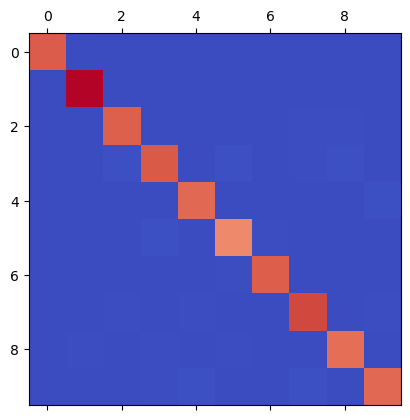

In [97]:
# an image representation of the confusion matrix might be more helpful

plt.matshow(conf_matrix, cmap='coolwarm', interpolation='nearest')

In [99]:
# let's plot the errors : let's do error rate for each class by dividing each vlaue of the confusion matrix with corresponding class

row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = conf_matrix / row_sums

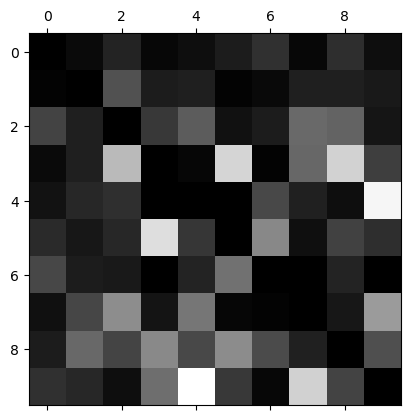

In [120]:
# fill the diagonal with zeros to keep only errors 
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [124]:
# EXTRA Taken from the book
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

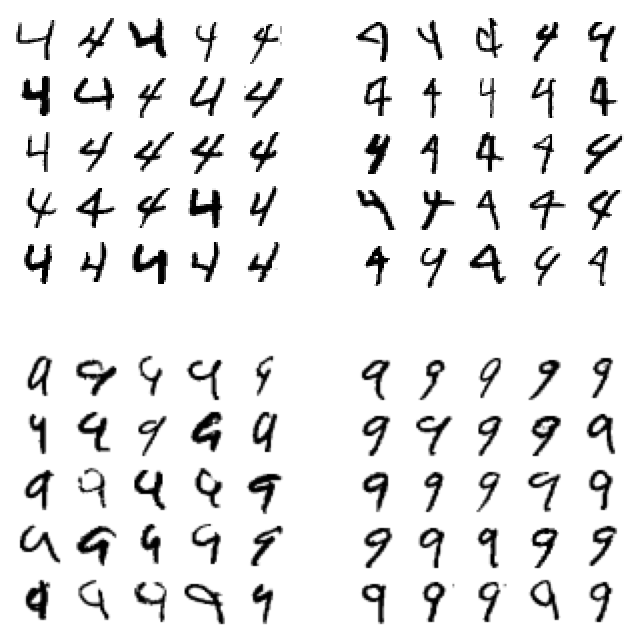

In [136]:
cl_a, cl_b = 4, 9
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [137]:
# similarly we can create multilabel system as well

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [138]:
knn_clf.predict(some_digit)

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [139]:
# evaluate this multi-class classifier: lets calculate F1 Score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

0.976410265560605

In [140]:
# finally, multiclass multilabel classification called multiclass classification
# as an example a classifier to clean noise from the image: each pixel has one label and one lable can have values ranging from 0 to 255, pixel intensity

#first let's put noise into the image

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test



In [143]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

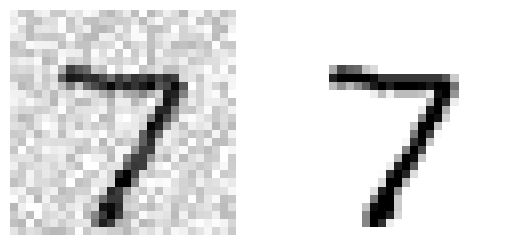

In [151]:
# unclean and clean digit
plt.subplot(121); plot_digits(X_test_mod[:1].values)
plt.subplot(122); plot_digits(y_test_mod[:1].values)
plt.show()

/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/chiragmacwan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


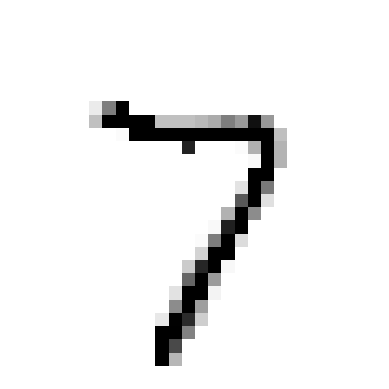

In [150]:
clean_digit = knn_clf.predict(X_test_mod[:1].values)
plot_digits(clean_digit)